Based on *Using a deep temporal convolutional network as a building energy surrogate model that spans multiple climate zones*
Recreation of Westermann et al., 2020

https://doi.org/10.1016/j.apenergy.2020.115563

https://gitlab.com/energyincities/building_surrogate_modelling

In [173]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py

# torch.cuda.empty_cache()

In [174]:
# print(f'PyTorch version: {torch.__version__}')
# print('*'*10)
# print(f'_CUDA version: ')
# !nvcc --version
# print('*'*10)
# print(f'CUDNN version: {torch.backends.cudnn.version()}')
# print(f'Available GPU devices: {torch.cuda.device_count()}')
# print(f'Device Name: {torch.cuda.get_device_name()}')
# print(torch.cuda.memory_summary())

In [175]:
# is_cuda_runtime =  torch.cuda.is_available()
# if not is_cuda_runtime:
#   print("Change your runtime to a GPU-accelerated one.")
# else:
#   print("All good!")
# device = "cuda" if is_cuda_runtime else "cpu"\
device="cpu"

Upload the bucket-ket.json file to the credentials folder

In [176]:
from storage import upload_to_bucket, download_from_bucket
from simulate import BatchSimulator
from schema import Schema

In [177]:
# !pip install vapeplot &> /dev/null

In [178]:
# @markdown ### 0.4 | Styling
# import google
import vapeplot # https://github.com/dantaki/vapeplot
import matplotlib
# is_dark = google.colab.output.eval_js(
#     'document.documentElement.matches("[theme=dark]")'
# )

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["savefig.dpi"] = 300
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)
plt.style.use("dark_background")
plt.rcParams.update(
    {
        "figure.facecolor": (0.22, 0.22, 0.22, 1.0),
        "axes.facecolor": (0.22, 0.22, 0.22, 1.0),
        "savefig.facecolor": (0.22, 0.22, 0.22, 1.0),
        "grid.color": (0.4, 0.4, 0.4, 1.0),
    }
)
# vapeplot.set_palette("mallsoft")
plt.set_cmap("plasma");

<Figure size 640x480 with 0 Axes>

# Download & preprocess the data

## Weather file & schedules preprocessing

In [179]:
# download_from_bucket(blob_name=f"climate_array.npy", file_name="./data/epws/climate_array.npy")
# download_from_bucket(blob_name=f"tsol.npy", file_name="./data/epws/tsol.npy")
# download_from_bucket(blob_name=f"default_schedules.npy", file_name="./data/template_libs/default_schedules.npy")

In [180]:
climate_array = np.load("./data/epws/climate_array.npy")
tsol_array = np.load("./data/epws/tsol.npy")

In [181]:
climate_array.shape

(392, 7, 8760)

Make a file in data called "hdf5"

In [182]:
test_batch = 25
# download_from_bucket(blob_name=f"final_results/batch_000{test_batch}_results.hdf5", file_name=f"./data/hdf5/batch_000{test_batch}_results.hdf5")

In [183]:
with h5py.File(f"./data/hdf5/batch_000{test_batch}_results.hdf5", 'r') as f:
    print(list(f.keys()))
    monthly = f["monthly"][...] # this loads the whole batch into memory!
    total_heating = f["total_heating"][...] # this loads the whole batch into memory!
    total_cooling = f["total_cooling"][...] # this loads the whole batch into memory!
    errors = f["errors"][...]
    area = f["area"][...]

['area', 'errors', 'hourly', 'monthly', 'total_cooling', 'total_heating', 'true_facade_hcp', 'true_roof_hcp', 'true_u']


In [184]:
monthly.shape

(1000, 4, 12)

In [185]:
monthly[0,1,:].max(), monthly[0,3,:].max()

(1156099328.0, 871119680.0)

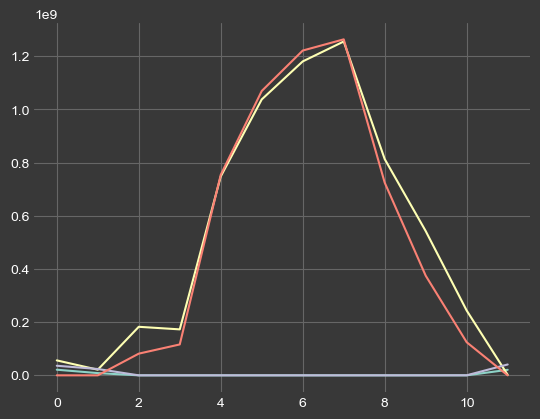

In [186]:
plt.plot(monthly[3,0,:])
plt.plot(monthly[3,1,:])
plt.plot(monthly[3,2,:])
plt.plot(monthly[3,3,:])

In [187]:
from schema import Schema, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation, WindowParameter, SchedulesParameters
schema = Schema()

batch_runner = BatchSimulator(schema, batch_id=test_batch, processes=5, input_bucket_slug="final_batches")
batch = batch_runner.storage_batch

INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 25
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 25...
INFO:Batch Simulator:Loaded BATCH:25, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:25...


In [188]:
data_size = area.shape[0]

## Normalization

First, let's set up the timeseries data

In [189]:
# TODO: normalize with the batch std? or recorded
# nornalization method?
# def normalize(data, mean, std):
    # return (data-mean)/std
def normalize(data, maxv, minv):
    return (data-minv)/(maxv-minv)

In [190]:
dbt_max = 50.0 # 50.5
dbt_min = -35.0
rh_max = 100.0
rh_min = 0.0 # 2.0
atm_max = 105800.0
atm_min = 75600.0
rad_min = 0.0
ghrad_max = 1200.0 #1154.0
dnrad_max = 1097.0
dhrad_max = 689.0
skyt_max = 32.3
skyt_min = -58.3
tsol_max = 60
tsol_min = -40

In [191]:
# Normalize the whole climate and tsol array
maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

norm_climate_array = np.zeros(climate_array.shape)
norm_tsol_array = np.zeros(tsol_array.shape)
for j in range(climate_array.shape[0]):
    for i in range(7):
        climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
    for i in range(4):
        norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

In [192]:
timeseries_vector = np.zeros((data_size, 8, 8760))

orientations = schema['orientation'].extract_storage_values_batch(batch).flatten()
idxs = schema['base_epw'].extract_storage_values_batch(batch).flatten()
# Get the weather file for each entry
for i, epw_idx in enumerate(idxs):
    epw_idx = int(epw_idx)
    timeseries_vector[i, :-1, :] = norm_climate_array[epw_idx]
    timeseries_vector[i, -1, :] = norm_tsol_array[epw_idx, int(orientations[i]), :]

Now for the building vector

In [193]:
building_vect_schema = [
    'width', 
    'height', 
    'facade_2_footprint', 
    'perim_2_footprint',
    'roof_2_footprint',
    'footprint_2_ground',
    'wwr',
    'orientation',
    'HeatingSetpoint',
    'CoolingSetpoint',
    'LightingPowerDensity',
    'EquipmentPowerDensity',
    'PeopleDensity',
    'Infiltration',
    'FacadeMass',
    'RoofMass',
    'FacadeRValue',
    'RoofRValue',
    'SlabRValue',
    ]
# Area
a_max = 2000
a_min = 0
wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

building_vector = np.zeros((data_size, 22))
for i, schema_name in enumerate(building_vect_schema):
    column = schema[schema_name].extract_storage_values_batch(batch).flatten()
    try:
        column = normalize(column, schema[schema_name].max, schema[schema_name].min)
    except:
        print(f"Calculating mean from batch data for {schema_name}...")
        column = normalize(column, np.max(column), np.min(column))
    building_vector[:, i] = column
building_vector[:, -3] = normalize(area, a_max, a_min)
building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

Calculating mean from batch data for orientation...


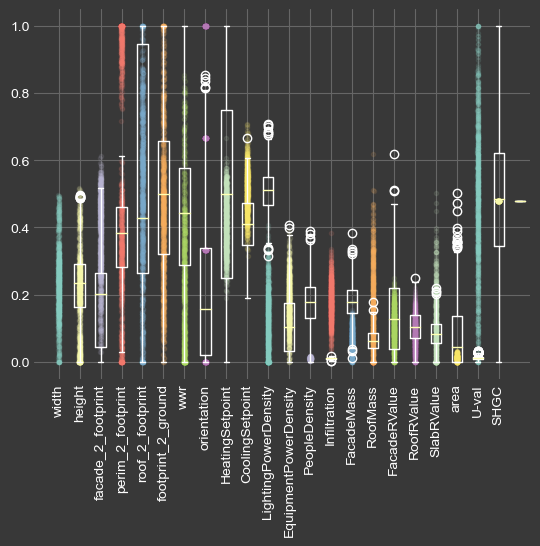

In [194]:
for c in range(22):
    y = building_vector[:, c]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(c, 0.01, size=len(y))
    plt.plot(x, y, '.', alpha=0.1)
plt.boxplot(building_vector)
plt.xticks(ticks = list(range(22)), labels=building_vect_schema + ["area", "U-val", "SHGC"], rotation = 90)
plt.show()

And finally, the output energy data 

In [195]:
#TODO separate min and max for heating and cooling?
energy_min = 0
energy_max = 7 * 10**9

# Add core and perimeter together
heating = monthly[:, 0, :]+monthly[:, 1, :]
cooling = monthly[:, 2, :]+monthly[:, 3, :]
norm_results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

norm_results = normalize(norm_results, energy_max, energy_min)

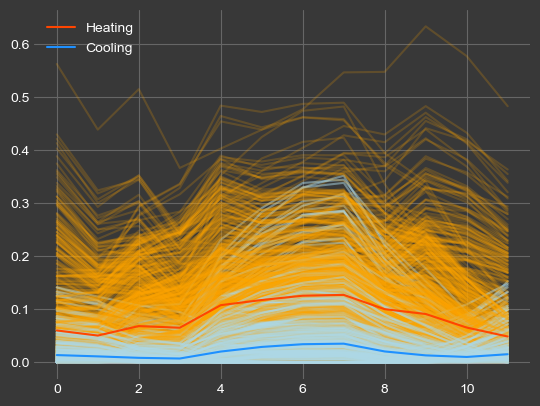

In [196]:
for i in range(1000):
    plt.plot(norm_results[i, 0, :], 'orange', alpha=0.2)
    plt.plot(norm_results[i, 1, :], 'lightblue', alpha=0.5)
plt.plot(np.mean(norm_results[:, 0, :], axis=0), 'orangered', label="Heating")
plt.plot(np.mean(norm_results[:, 1, :], axis=0), 'dodgerblue', label="Cooling")
plt.legend()
plt.show()

In [197]:
# TODO: WHY ARE THERE NEGATIVES IN THE MONTHLY DATA?
norm_results.min(), norm_results.max()

(-2.857142857142857e-10, 0.6326354651428572)

In [198]:
# the loading & preprocessing grouped into a function
def load_training_samples(batch_no, schema,
    dbt_max = 50.0, # 50.5
    dbt_min = -35.0,
    rh_max = 100.0,
    rh_min = 0.0, # 2.0
    atm_max = 105800.0,
    atm_min = 75600.0,
    rad_min = 0.0,
    ghrad_max = 1200.0, #1154.0
    dnrad_max = 1097.0,
    dhrad_max = 689.0,
    skyt_max = 32.3,
    skyt_min = -58.3,
    tsol_max = 60,
    tsol_min = -40,
    a_max = 2000,
    a_min = 0,
    energy_min = 0,
    energy_max = 7 * 10**9,
):
    try:
        h5py.File(f"./data/hdf5/batch_{batch_no:05d}_results.hdf5", 'r')
    except:
        download_from_bucket(blob_name=f"final_results/batch_{batch_no:05d}_results.hdf5", file_name=f"./data/hdf5/batch_{batch_no:05d}_results.hdf5")
    with h5py.File(f"./data/hdf5/batch_{batch_no:05d}_results.hdf5", 'r') as f:
        monthly = f["monthly"][...] # this loads the whole batch into memory!
        total_heating = f["total_heating"][...] # this loads the whole batch into memory!
        total_cooling = f["total_cooling"][...] # this loads the whole batch into memory!
        errors = f["errors"][...]
        area = f["area"][...]
    batch_runner = BatchSimulator(schema, batch_id=batch_no, processes=5, input_bucket_slug="final_batches")
    batch = batch_runner.storage_batch

    # Normalize the whole climate and tsol array
    maxes = [dbt_max, rh_max, atm_max, ghrad_max, dnrad_max, dhrad_max, skyt_max]
    mins = [dbt_min, rh_min, atm_min, rad_min, rad_min, rad_min, skyt_min]

    norm_climate_array = np.zeros(climate_array.shape)
    norm_tsol_array = np.zeros(tsol_array.shape)
    for j in range(climate_array.shape[0]):
        for i in range(7):
            climate_array[j, i, :] = normalize(climate_array[j, i, :], maxes[i], mins[i])
        for i in range(4):
            norm_tsol_array[j, i, :] = normalize(tsol_array[j, i, :], tsol_max, tsol_min)

    timeseries_vector = np.zeros((data_size, 8, 8760))
    orientations = schema['orientation'].extract_storage_values_batch(batch).flatten()
    idxs = schema['base_epw'].extract_storage_values_batch(batch).flatten()
    # Get the weather file for each entry
    for i, epw_idx in enumerate(idxs):
        epw_idx = int(epw_idx)
        timeseries_vector[i, :-1, :] = norm_climate_array[epw_idx]
        timeseries_vector[i, -1, :] = norm_tsol_array[epw_idx, int(orientations[i]), :]
    wind_settings = schema["WindowSettings"].extract_storage_values_batch(batch)

    building_vector = np.zeros((data_size, 22))
    for i, schema_name in enumerate(building_vect_schema):
        column = schema[schema_name].extract_storage_values_batch(batch).flatten()
        try:
            column = normalize(column, schema[schema_name].max, schema[schema_name].min)
        except:
            print(f"Calculating mean from batch data for {schema_name}...")
            column = normalize(column, np.max(column), np.min(column))
        building_vector[:, i] = column
    building_vector[:, -3] = normalize(area, a_max, a_min)
    building_vector[:, -2] = normalize(wind_settings[:, 0].flatten(), schema["WindowSettings"].max[0], schema["WindowSettings"].min[0]) # U-val
    building_vector[:, -1] = normalize(wind_settings[:, 1].flatten(), schema["WindowSettings"].max[1], schema["WindowSettings"].min[1]) # shgc

    # Add core and perimeter together
    heating = monthly[:, 0, :]+monthly[:, 1, :]
    cooling = monthly[:, 2, :]+monthly[:, 3, :]
    norm_results = np.concatenate((np.expand_dims(heating, 1), np.expand_dims(cooling, 1)), axis=1)

    norm_results = normalize(norm_results, energy_max, energy_min)
    # TODO: MAKE THIS EUI?

    return building_vector, timeseries_vector, norm_results

In [199]:
print(building_vector.shape)
print(timeseries_vector.shape)
print(norm_results.shape)

(1000, 22)
(1000, 8, 8760)
(1000, 2, 12)


In [200]:
%%time
n_batches = 10
list_batches = np.random.randint(low=0, high=392, size=(n_batches))
print(list_batches)
for i in list_batches:
    bv, tv, res = load_training_samples(300, schema)
    building_vector = np.concatenate((building_vector, bv), axis=0)
    timeseries_vector = np.concatenate((timeseries_vector, tv), axis=0)
    norm_results = np.concatenate((norm_results, res), axis=0)
print(building_vector.shape)
print(timeseries_vector.shape)
print(norm_results.shape)

INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


[155 231 223   1 279 251  81  88 183 148]


INFO:Batch Simulator:--------- Batch Simulation ---------


Calculating mean from batch data for orientation...


INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...


INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 300
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 300...
INFO:Batch Simulator:Loaded BATCH:300, which has 1000 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:300...


Calculating mean from batch data for orientation...
(11000, 22)
(11000, 8, 8760)
(11000, 2, 12)
CPU times: total: 9.67 s
Wall time: 11.2 s


# Set up the model

## Timeseries CNN

In [232]:
import torch.nn as nn
import torch.optim as optim

class EnergyTimeseriesCNNBlockA(nn.Module):
    def __init__(self, 
                 in_channels=8,
                 out_channels=8,
                 n_feature_maps = 64,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
            nn.BatchNorm1d(n_feature_maps), 
        )

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)

class EnergyTimeseriesCNNBlockB(nn.Module):
    def __init__(self, 
                 in_channels=128,
                 out_channels=128,
                 n_feature_maps = 128,
                 ):
        super().__init__()

        self.n_feature_maps=n_feature_maps

        self.input_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=8,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.mid_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=5,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.final_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=n_feature_maps,
                kernel_size=3,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
        )

        self.skip_layer = nn.BatchNorm1d(n_feature_maps)

    def forward(self, x):
        x_skip = self.skip_layer(x)
        
        x_out = self.input_convolutional_layer(x)
        x_out = nn.functional.relu(x_out)

        x_out = self.mid_convolutional_layer(x_out)
        x_out = nn.functional.relu(x_out)

        x_out = self.final_convolutional_layer(x_out)
        
        x_out = x_out + x_skip
        
        return nn.functional.relu(x_out)


class AnnualEnergyCNN(nn.Module):
    def __init__(self, 
               in_channels=8,
               out_channels=8,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR ANNUAL
        self.GlobalAveragePool = nn.AvgPool1d(kernel_size=8760) # 1D? average across all feature maps
        self.linear = nn.Linear(in_features=n_feature_maps*2, out_features=out_channels)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.GlobalAveragePool(x)
        x = x.squeeze(-1)
        x = self.linear(x)
        return nn.functional.relu(x)

class MonthlyEnergyCNN(nn.Module):
    def __init__(self, 
               in_channels=8,
               out_channels=8,
               n_feature_maps = 64,
               ):
        super().__init__()

        self.resblock_1 = EnergyTimeseriesCNNBlockA(
            n_feature_maps=n_feature_maps
            )
        
        self.resblock_2 = EnergyTimeseriesCNNBlockA(
            in_channels=n_feature_maps,
            n_feature_maps=n_feature_maps*2
            )
        
        # no need to expand channels in third layer because they are equal
        self.resblock_3 = EnergyTimeseriesCNNBlockB(
            in_channels=n_feature_maps*2,
            n_feature_maps=n_feature_maps*2
            )
        
        # FOR MONTHLY (out is 2x12)
        self.month_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps*2,
                out_channels=out_channels,
                kernel_size=30,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
        )   
        self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, x):
        x = self.resblock_1(x)
        x = self.resblock_2(x)
        x = self.resblock_3(x)
        x = self.pooling(x)
        x = self.month_convolutional_layer(x)
        return nn.functional.relu(x)

In [233]:
timeseries_model = MonthlyEnergyCNN().to(device)

In [234]:
from torchsummary import summary
summary(timeseries_model, (8, 8760))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

## Energy surrogate

In [235]:
class EnergyCNN(torch.nn.Module):
    def __init__(self, 
                 in_channels=30,
                 n_feature_maps=64,
                 out_channels=2
                 ):
        super(EnergyCNN, self).__init__()

        # FOR MONTHLY (out is 2x12)
        self.in_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=in_channels,
                out_channels=n_feature_maps,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(n_feature_maps),
            )
        
        self.out_convolutional_layer = nn.Sequential(
            nn.Conv1d(
                in_channels=n_feature_maps,
                out_channels=out_channels,
                kernel_size=2,
                stride=1,
                padding='same',
            ),
            nn.BatchNorm1d(out_channels),
            )  
        # self.pooling = nn.AvgPool1d(kernel_size=730)

    def forward(self, sample):
        # sample (22+n, 1)
        x = self.in_convolutional_layer(sample)
        x = nn.functional.leaky_relu(x)
        x = self.out_convolutional_layer(x)
        x = nn.functional.leaky_relu(x)

        return x

In [236]:
energy_model = EnergyCNN().to(device)

In [ ]:
summary(energy_model, (30, 12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 12]           3,904
       BatchNorm1d-2               [-1, 64, 12]             128
            Conv1d-3                [-1, 2, 12]             258
       BatchNorm1d-4                [-1, 2, 12]               4
Total params: 4,294
Trainable params: 4,294
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [ ]:
# class EnergyMLP(torch.nn.Module):
#     def __init__(self, 
#                  timeseriesEncoder=AnnualEnergyCNN, 
#                  in_channels=30,
#                  n_feature_maps=64,
#                  out_channels=2
#                  ):
#         super(EnergyMLP, self).__init__()

#         self.timeseriesEncoder = timeseriesEncoder().to(device)

#         # FOR ANNUAL
#         self.denseIn = nn.Linear(in_features=in_channels, out_features=n_feature_maps)
#         self.denseOut = nn.Linear(in_features=n_feature_maps, out_features=out_channels)

#     def forward(self, sample):
#         # sample (22+n, 1)

#         x = self.denseIn(sample)
#         x = nn.functional.leaky_relu(x)
#         x = self.denseOut(x)
#         x = nn.functional.leaky_relu(x)

#         return x

## Dataloaders

First, split the data into training, validation, and testing (80/10/10).

In [203]:
print(building_vector.shape)
print(timeseries_vector.shape)
print(norm_results.shape)

(11000, 22)
(11000, 8, 8760)
(11000, 2, 12)


In [204]:
norm_results.min(), norm_results.max()

(-2.857142857142857e-10, 0.6326354651428572)

In [224]:
list_batches = np.random.randint(low=0, high=building_vector.shape[0], size=(2000))
dataset = {}
for j, i in enumerate(list_batches):
    # DICT ENTRIES MUST BE IN ORDER
    dataset[j] = dict({
        "building_vector": np.array([building_vector[i]]*12).T,
        "timeseries_vector": timeseries_vector[i],
        "results_vector": norm_results[i],
    })


In [225]:
len(dataset.keys())

2000

In [226]:
generator = torch.Generator()
generator.manual_seed(0)

train, val, test = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=generator)

In [229]:
batch_size = 32
training_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
validation_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)


# Train the model

In [237]:
timeseries_model.train()

MonthlyEnergyCNN(
  (resblock_1): EnergyTimeseriesCNNBlockA(
    (input_convolutional_layer): Sequential(
      (0): Conv1d(8, 64, kernel_size=(8,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mid_convolutional_layer): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (final_convolutional_layer): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_layer): Sequential(
      (0): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblock_2): EnergyTimeseriesCNNBlockA(
    (input_convolutional_layer): Sequential(
      (0): Conv1d(64, 128, k

In [238]:
energy_model.train()

EnergyCNN(
  (in_convolutional_layer): Sequential(
    (0): Conv1d(30, 64, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_convolutional_layer): Sequential(
    (0): Conv1d(64, 2, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
# print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 13           |        cudaMalloc retries: 14        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   3451 MiB |   3493 MiB |   6632 MiB |   3180 MiB |
|       from large pool |   3449 MiB |   3491 MiB |   6628 MiB |   3179 MiB |
|       from small pool |      2 MiB |      3 MiB |      3 MiB |      1 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   3451 MiB |   3493 MiB |   6632 MiB |   3180 MiB |
|       from large pool |   3449 MiB |   3491 MiB |   6628 MiB |

In [239]:
n_epochs = 20
learning_rate = 1e-3
step_loss_frequency = 50
training_loss_history = []
validation_loss_history  = []
latentvect_history  = []

# LOSS FUNCTION
loss_function = nn.MSELoss()

# optimizer = torch.optim.Adam(energy_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(timeseries_model.parameters()) + list(energy_model.parameters()), lr=learning_rate)

for epoch_num in range(n_epochs):
    print(f"------------------epoch number {epoch_num}------------------")
    for j, sample in enumerate(training_dataloader):
        optimizer.zero_grad()
        
        timeseries = sample["timeseries_vector"].to(device).float()
        timeseries = torch.clamp(timeseries, min=0, max=1)
        bldg_vect = sample["building_vector"].to(device).float()
        bldg_vect = torch.clamp(bldg_vect, min=0, max=1)
        # Repeat bldg_vect for monthly size:
        loads = sample["results_vector"].to(device).float()
        loads = torch.clamp(loads, min=0, max=1)

        timeseries_latvect = timeseries_model(timeseries)

        # Concatenate vectors
        x = torch.cat([timeseries_latvect, bldg_vect], axis=1).squeeze(1)
        # print(x.shape)

        predicted_loads = energy_model(x)

        loss = loss_function(loads, predicted_loads)

        if j%step_loss_frequency == 0:
            print(f"Step {j} loss: {loss.item()}")
            latentvect_history.append(timeseries_latvect.detach())
        
        training_loss_history.append([len(training_loss_history),loss.item()])

        loss.backward()
        optimizer.step()

    with torch.no_grad():
        epoch_validation_loss = []
        for sample in validation_dataloader:
            # SET UP SAMPLE DATA
            timeseries_val = sample["timeseries_vector"].to(device).float()
            timeseries_val = torch.clamp(timeseries_val, min=0, max=1)
            # print(timeseries.shape)
            bldg_vect_val = sample["building_vector"].to(device).float()
            bldg_vect_val = torch.clamp(bldg_vect_val, min=0, max=1)
            # Repeat bldg_vect for monthly size:
            # bldg_vect_month_val = np.repeat(bldg_vect_val.unsqueeze(2), 12, axis=2)
            loads = sample["results_vector"].to(device).float()
            loads = torch.clamp(loads, min=0, max=1)

            timeseries_latvect_val = timeseries_model(timeseries_val)

            # Concatenate vectors
            x_val = torch.cat([timeseries_latvect_val, bldg_vect_val], axis=1).squeeze(1)

            predicted_loads = energy_model(x_val)

            loss = loss_function(loads, predicted_loads)
            
            epoch_validation_loss.append(loss.item())

        mean_validation_loss = np.mean(epoch_validation_loss)
        print(f"Mean validation loss for batch: {mean_validation_loss}")

        validation_loss_history.append([len(training_loss_history), mean_validation_loss])

------------------epoch number 0------------------
Step 0 loss: 0.448453426361084
Mean validation loss for batch: 0.015157656211938177
------------------epoch number 1------------------
Step 0 loss: 0.015649231150746346
Mean validation loss for batch: 0.006276107692558851
------------------epoch number 2------------------
Step 0 loss: 0.005978969391435385
Mean validation loss for batch: 0.004532394049290035
------------------epoch number 3------------------
Step 0 loss: 0.003711707191541791
Mean validation loss for batch: 0.0037444763417754856
------------------epoch number 4------------------
Step 0 loss: 0.0026814814191311598
Mean validation loss for batch: 0.0033709644838901503
------------------epoch number 5------------------
Step 0 loss: 0.0022989825811237097


In [ ]:
# Save checkpoint
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M")
uid = 'ZL'
torch.save({
    'epoch': epoch_num,
    'model_state_dict': timeseries_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    f"./checkpoints/{timestamp}_timeseries_{uid}.pt"
)
torch.save({
    'epoch': epoch_num,
    'model_state_dict': energy_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
    },
    f"./checkpoints/{timestamp}_energy_{uid}.pt"
)

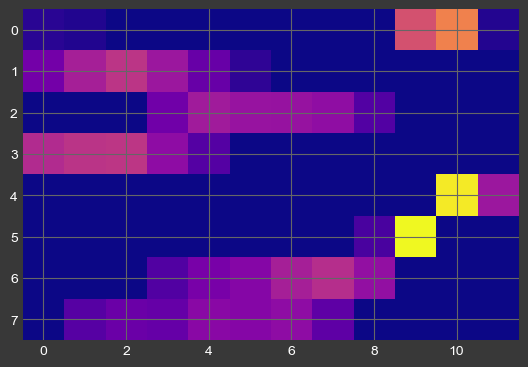

In [46]:
# do a visualization of data after each block?
plt.imshow(timeseries_latvect[0].detach().numpy())

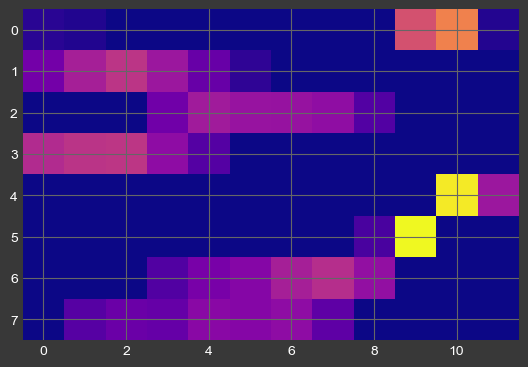

In [48]:
plt.imshow(timeseries_latvect[2].detach().numpy())


In [49]:
timeseries_latvect.shape

torch.Size([50, 8, 12])

Plot the training and validation loss and history

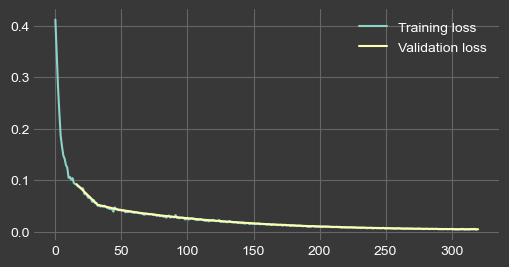

In [50]:
training_loss_history_array = np.array(training_loss_history)
validation_loss_history_array = np.array(validation_loss_history)

plt.figure(figsize=(6,3))
plt.plot(training_loss_history_array[:,0],training_loss_history_array[:,1], label="Training loss")
plt.plot(validation_loss_history_array[:,0],validation_loss_history_array[:,1], label="Validation loss")
plt.legend()
plt.show()

## Testing

In [52]:
timeseries_model.eval()
energy_model.eval()

EnergyCNN(
  (in_convolutional_layer): Sequential(
    (0): Conv1d(30, 64, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out_convolutional_layer): Sequential(
    (0): Conv1d(64, 2, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [69]:
with torch.no_grad():
    test_samples = next(iter(test_dataloader))
    timeseries = test_samples["timeseries_vector"].to(device).float()
    bldg_vect = test_samples["building_vector"].to(device).float()
    loads = test_samples["results_vector"].to(device).float()

    timeseries_latvect = timeseries_model(timeseries)

    # Concatenate vectors
    x = torch.cat([timeseries_latvect, bldg_vect], axis=1).squeeze(1)

    predicted_loads = energy_model(x)

    loss = loss_function(loads, predicted_loads)

    print(f"Testing loss: {loss.item()}")

Testing loss: 0.0038220989517867565


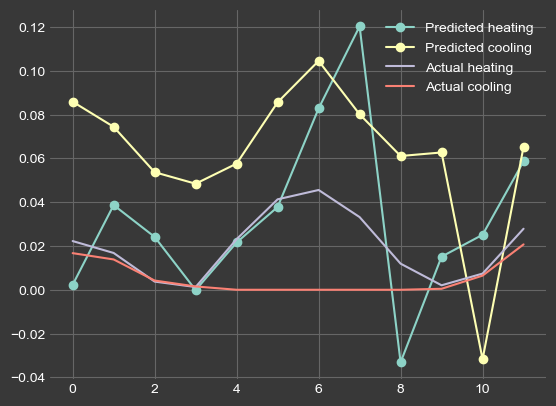

In [95]:
i = 1
plt.plot(predicted_loads[i, 0, :], "-o",label="Predicted heating")
plt.plot(predicted_loads[i, 1, :], "-o",label="Predicted cooling")
plt.plot(loads[i, 0, :], label="Actual heating")
plt.plot(loads[i, 1, :], label="Actual cooling")
plt.legend()
plt.show()

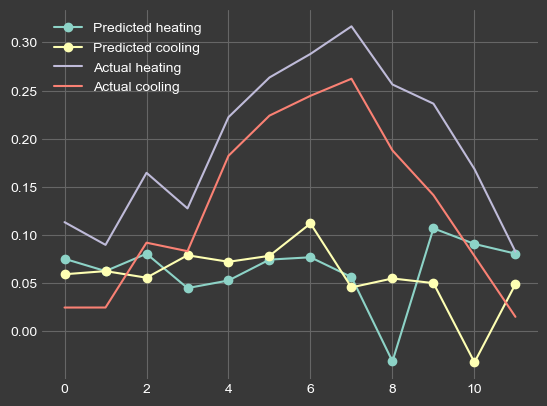

In [96]:
i = 5
plt.plot(predicted_loads[i, 0, :], "-o",label="Predicted heating")
plt.plot(predicted_loads[i, 1, :], "-o",label="Predicted cooling")
plt.plot(loads[i, 0, :], label="Actual heating")
plt.plot(loads[i, 1, :], label="Actual cooling")
plt.legend()
plt.show()

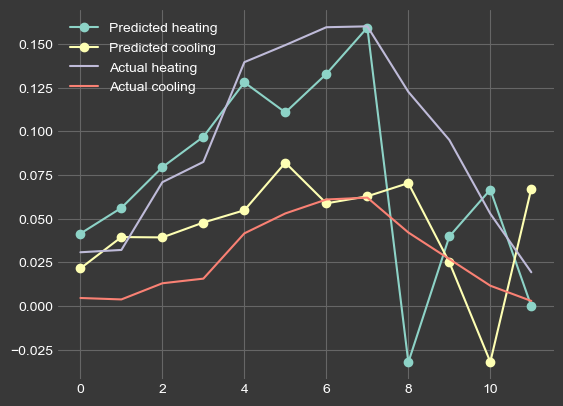

In [94]:
i = 9
plt.plot(predicted_loads[i, 0, :], "-o",label="Predicted heating")
plt.plot(predicted_loads[i, 1, :], "-o",label="Predicted cooling")
plt.plot(loads[i, 0, :], label="Actual heating")
plt.plot(loads[i, 1, :], label="Actual cooling")
plt.legend()
plt.show()

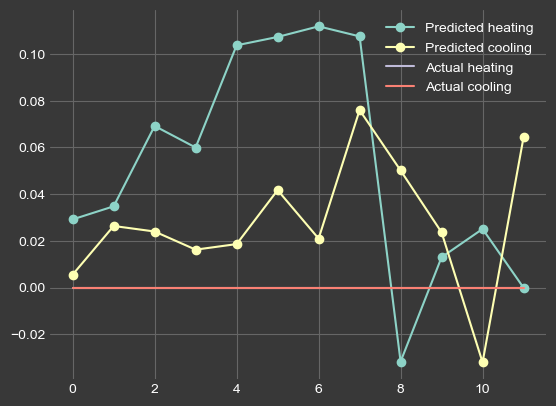

In [99]:
i = 30
plt.plot(predicted_loads[i, 0, :], "-o",label="Predicted heating")
plt.plot(predicted_loads[i, 1, :], "-o",label="Predicted cooling")
plt.plot(loads[i, 0, :], label="Actual heating")
plt.plot(loads[i, 1, :], label="Actual cooling")
plt.legend()
plt.show()

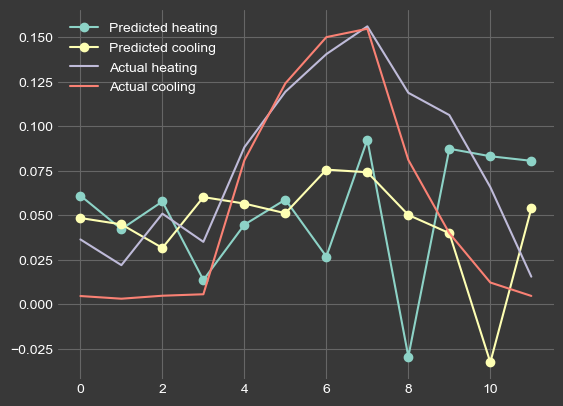

In [100]:
i = 20
plt.plot(predicted_loads[i, 0, :], "-o",label="Predicted heating")
plt.plot(predicted_loads[i, 1, :], "-o",label="Predicted cooling")
plt.plot(loads[i, 0, :], label="Actual heating")
plt.plot(loads[i, 1, :], label="Actual cooling")
plt.legend()
plt.show()

In [ ]:
# Error metrics
'''
* MAPE
* nMBE
* R2
* RMSE
* RMSPE
'''


# Visualizations
- Latent space
- 